In [1]:
import sys
sys.path.append("/b2p")

In [2]:
%matplotlib notebook 
import matplotlib.pyplot as plt
import os
from glob import glob 
import rasterio
from rasterio import features
from rasterio.windows import Window
import geopandas as gpd
import numpy as np
import copy
from tqdm.notebook import tqdm 
import warnings
# filter out RuntimeWarnings, due to geopandas/fiona read file spam
# https://stackoverflow.com/questions/64995369/geopandas-warning-on-read-file
warnings.filterwarnings("ignore",category=RuntimeWarning)

<IPython.core.display.Javascript object>


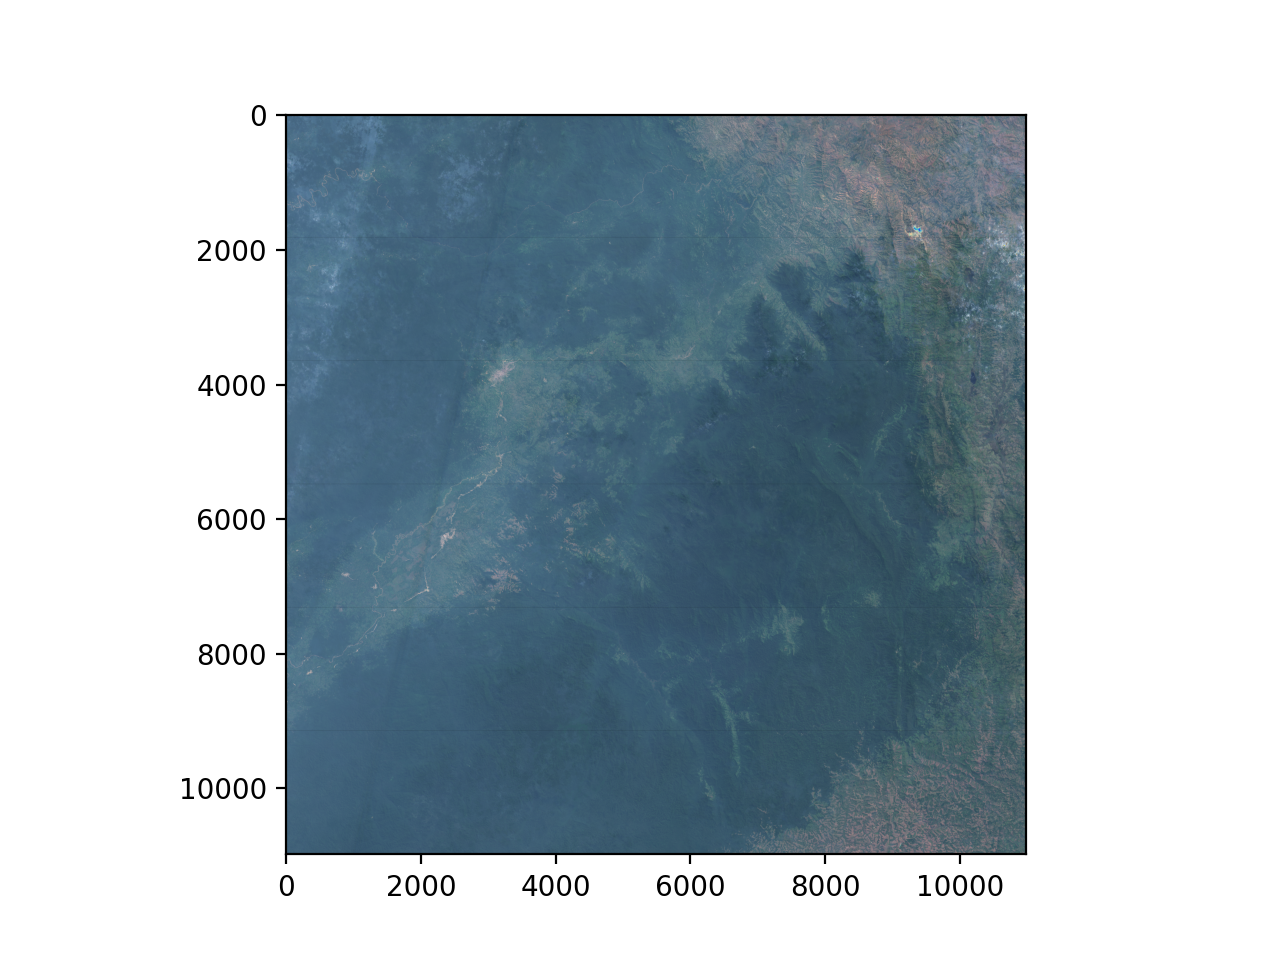

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [6]:
from sklearn import preprocessing as p
def plotNormalizedImg(data, ax):
    min_max_scaler = p.MinMaxScaler()
    normalizedData = min_max_scaler.fit_transform(data.astype(np.float64))*255

    normalizedData = np.round(normalizedData).astype(np.uint8)
    
    ax.imshow(normalizedData)
    plt.show()
    
img = None
with rasterio.open('./data/composites/Rwanda/all/35MPS_multiband.tiff') as rf:
    b4 = rf.read(1)
    b3 = rf.read(2) 
    b2 = rf.read(3) 
    W, H = b2.shape
    img = np.zeros((W,H, 3))
    img[:,:,0] = b4
    img[:,:,1] = b3
    img[:,:,2] = b2

In [20]:
uintImg = np.minimum(img / 2000,1.0)

<IPython.core.display.Javascript object>


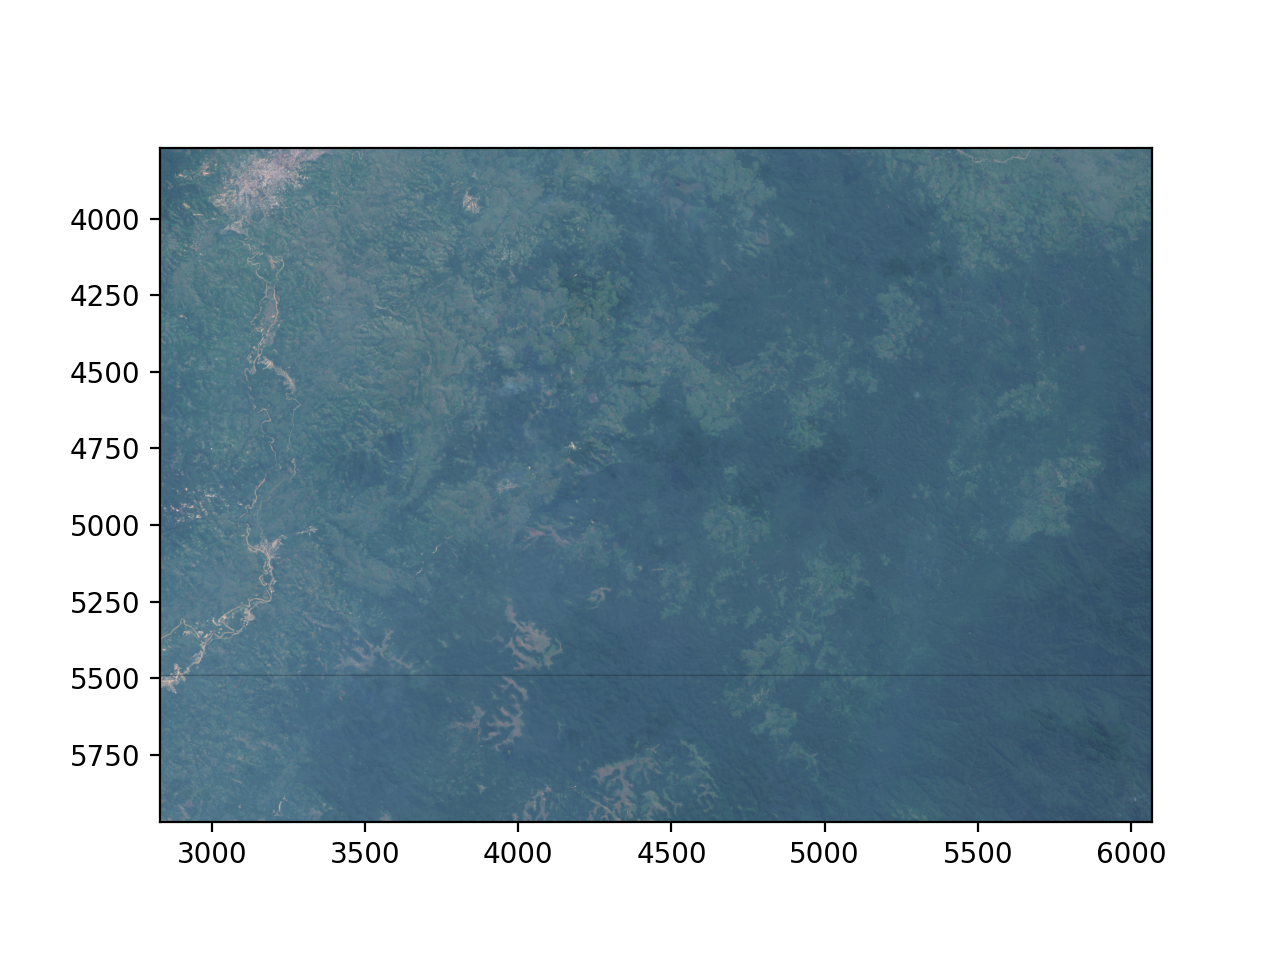

In [21]:
plt.subplots()
plt.imshow(uintImg)
plt.show()

In [ ]:
import subprocess 
subprocess.Popen('rsync -av ./data/composites/Rwanda/all/35MPS_multiband.tiff'

In [ ]:
# set inputs
s2_dir = '/b2p/data/tmp_s2/Rwanda/all'
bands = ['B02', 'B03','B04']
composite_dir = './data/test_composite'
dtype = np.float32
num_slices = 6

In [ ]:
with rasterio.open(outpath, 'w', driver='Gtiff', width=g_ncols, height=g_nrows, count=1, crs=crs,
                                   transform=transform, dtype=dtype) as wf:
        wf.write(median_corrected.astype(dtype), 1)

In [ ]:
from scipy.stats import norm
dif = np.diff(median_corrected, axis=1) # right col minus left
data = dif.mean(axis=0)
mu, std = norm.fit(data)
plt.subplots()
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [ ]:
from src.api.sentinel2 import SinergiseSentinelAPI

# Download New Data

In [ ]:
from src.api.sentinel2 import SinergiseSentinelAPI
buffer = 100
api = SinergiseSentinelAPI()

In [ ]:
# Rwanda (first month of dry szn)
bbox = [28.7869, -3.6889, 30.9732, -0.1978]
outdir = './data/tmp_s2/Rwanda/all'
start_date = '2018-06-01'
end_date = '2018-07-31'

In [ ]:
os.makedirs(outdir, exist_ok=True)
api.download(bbox, buffer, outdir, start_date, end_date)

In [ ]:
# Uganda
d_to_bbox = { Kabarole: [30.0675, 0.1847, 30.6141, 1.0581],
    Kasese: [29.4585, -0.7429, 30.5516, 1.0038],
    Ibanda: [30.1691, -0.4964, 30.7157, 0.3770]
}
for district, bbox in d_to_bbox.items():
    outdir = os.path.join('./data/tmp_s2/Rwanda', district)
    # get first dry szn
    start_date = '2019-06-15'
    end_date = '2019-08-15'
    os.makedirs(outdir, exist_ok=True)
    api.download(bbox, buffer, outdir, start_date, end_date)
    start_date = '2019-01-01'
    end_date = '2019-02-28'

# Subset of Training Data

In [ ]:
from glob import glob
from tqdm.notebook import tqdm
import os 
import pandas as pd
import numpy as np
import multiprocessing as mp
import random 
import subprocess


In [ ]:
geo_loc_files = glob('/b2p/data/final_tiles/**/*.csv', recursive=True)
geo_loc_files = [f for f in geo_loc_files if 'Uganda' in f or 'Rwanda' in f]

In [ ]:
# sanity check this is in cote d'ivore
any(['29NPE_geoloc.csv' in csv for csv in geo_loc_files])

In [ ]:
dfs = [] 
def _task(csv):
    df = pd.read_csv(csv)
    root, _ = os.path.split(csv)
    df['tile'] = df.apply(lambda row: os.path.join(root, row['tile'].split('tmp_tiles/')[1]), axis = 1)
    return df 

In [ ]:
# test on one file
csv = geo_loc_files[0]
df = _task(csv)

In [ ]:
df = None
with mp.Pool(6) as p:
    dfs = tqdm(p.map(_task, geo_loc_files))
    df = pd.concat(dfs, ignore_index=True)

In [ ]:
df['country'] = df.apply(lambda row: row['tile'].split('/')[-4], axis=1)

In [ ]:
num_found = df.loc[df['country'] == 'Uganda',"is_bridge"].to_numpy().sum()
print(f'Number of bridge locations, {num_found}')
print(f'Number of ties, {df.shape[0]}')


In [ ]:
df

In [ ]:
df.to_csv('data/final_tiles/geoloc_rwanda_uganda_training.csv')

In [ ]:
out_dir = 'data/final_tiles/'
# Seperate the training and validation into seperate files
b_ix = df.index[df['is_bridge']].tolist()
nb_ix = df.index[False == df['is_bridge']].tolist()
b_train_ix = random.sample(b_ix, int(round(0.7*len(b_ix))))
nb_train_ix = random.sample(nb_ix, int(round(0.7*len(nb_ix))))
b_val_ix = np.setdiff1d(b_ix, b_train_ix)
nb_val_ix = np.setdiff1d(nb_ix, nb_train_ix)
print(f'b_train_ix: {len(b_train_ix)}')
print(f'nb_train_ix: {len(nb_train_ix)}')
print(f'b_val_ix: {len(b_val_ix)}')
print(f'nb_val_ix: {len(nb_val_ix)}')

train_csv = os.path.join(out_dir, 'train_df.csv')
val_csv = os.path.join(out_dir, 'val_df.csv')
train_df = pd.concat(
    [
        df.iloc[b_train_ix],
        df.iloc[nb_train_ix]
    ], 
    ignore_index=True
)
val_df = pd.concat(
    [
        df.iloc[b_val_ix],
        df.iloc[nb_val_ix]
    ], 
    ignore_index=True
)
train_df.to_csv(train_csv) 
val_df.to_csv(val_csv) 
print(f'Saving to {train_csv} and {val_csv}')

In [ ]:
out_dir = 'data/final_tiles/'
# Make a training set where the # of bridge tiles == # of no bridge tiles
b_ix = df.index[df['is_bridge']].tolist()
nb_ix = df.index[False == df['is_bridge']].tolist()
b_train_ix = random.sample(b_ix, int(round(0.7*len(b_ix))))
nb_train_ix = random.sample(nb_ix, int(round(0.7*len(b_ix))))
b_val_ix = np.setdiff1d(b_ix, b_train_ix)
nb_val_ix = np.setdiff1d(nb_ix, nb_train_ix)
nb_val_ix = random.sample(nb_val_ix.tolist(), len(b_val_ix))
print(f'b_train_ix: {len(b_train_ix)}')
print(f'nb_train_ix: {len(nb_train_ix)}')
print(f'b_val_ix: {len(b_val_ix)}')
print(f'nb_val_ix: {len(nb_val_ix)}')

train_csv = os.path.join(out_dir, 'train_df_lite.csv')
val_csv = os.path.join(out_dir, 'val_df_lite.csv')
train_df = pd.concat(
    [
        df.iloc[b_train_ix],
        df.iloc[nb_train_ix]
    ], 
    ignore_index=True
)
val_df = pd.concat(
    [
        df.iloc[b_val_ix],
        df.iloc[nb_val_ix]
    ], 
    ignore_index=True
)
train_df.to_csv(train_csv) 
val_df.to_csv(val_csv) 
print(f'Saving to {train_csv} and {val_csv}')

In [ ]:
from bin.get_optical_data import upload_to_s3
print('-----------------------------')
print('Compressing raw s2')
tile_dir = './data/final_tiles'
tar_file = './final_tiles.tar.gz'
tar_cmd = f'tar -czvf {tar_file} {tile_dir}'
print(tar_cmd)


In [ ]:
process = subprocess.Popen(tar_cmd.split(), shell=False)
process.communicate()
# Upload raw s2 to s3
print('Uploading to s3')
upload_to_s3(
    tar_file, 
    os.path.join('sentinel2_raw', os.path.basename(tar_file))
)

## Inspect tiles

In [ ]:
import torch 
from glob import glob 
from bin.composites_to_tiles import get_bridge_locations
from bin.composites_to_tiles import bridge_in_bbox
from src.utilities.coords import tiff_to_bbox

In [ ]:
bridge_locs = get_bridge_locations('data/ground_truth')

In [ ]:
multiband_tiff = None
for c in glob('data/composites/**/*.tiff', recursive=True):
    bbox = tiff_to_bbox(c)
    if bridge_in_bbox(bbox, bridge_locs):
        multiband_tiff = c 
        print(c)
        break

In [ ]:
prefix = os.path.basename(multiband_tiff)[:5]
tile = glob(f'data/final_tiles/**/{prefix}/*', recursive=True)

In [ ]:
for t in tile[:10]:
    print(torch.load(t).shape)

## Sanity Check on Images

In [ ]:
%matplotlib notebook
from src.ml.train import * 
import matplotlib.pyplot as plt
import time

In [ ]:
dset = B2PDataset('data/tiles/val_df_lite.csv')
ix_to_label = ['no_bridge', 'bridge']

In [ ]:
img, label, tile, bbox = dset[0]
print(tile)
print(ix_to_label[label])
img = (img.permute(1, 2, 0).numpy()*255).astype(np.uint8)
plt.imshow(img, aspect='auto',  vmin=0, vmax=255)

In [ ]:
plt.imshow(img.permute(1,2,0))
plt.show()

## Accuracy Plots

In [1]:
import plotly.express as px
from glob import glob 
import os, torch
import pandas as pd

In [2]:
models = ['resnet18','resnet34','resnet50']
torch_dir = 'data/torch'
inf_dir = 'data/inference'
df = pd.DataFrame(columns=['model', 'epoch', 'total_acc', 'bridge_acc', 'no_bridge_acc'])

In [3]:
for model in models:
    for chkpt in glob(os.path.join(torch_dir, model, '*chkpt*')):
        state_dict = torch.load(chkpt)
        epoch = int(chkpt.split('.')[-2].split('chkpt')[1])
#         print(epoch)
        df.loc[len(df.index)] = [model, epoch, state_dict['total_acc'], state_dict['bridge_acc'], state_dict['no_bridge_acc']]


In [5]:
fig = px.line(df, x='epoch', y="total_acc", color="model", symbol="model", markers=True)
fig.write_image("data/torch/total_acc.png")
fig.show()

In [6]:
fig = px.line(df, x='epoch', y="bridge_acc", color="model", symbol="model", markers=True)
fig.write_image("data/torch/bridge_acc.png")
fig.show()

In [7]:
fig = px.line(df, x='epoch', y="no_bridge_acc", color="model", symbol="model", markers=True)
fig.write_image("data/torch/no_bridge_acc.png")
fig.show()

## Inference Results

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv('data/inference/resnet18/cote_divore.csv')

In [10]:
df.columns

Index(['Unnamed: 0', 'tile', 'bbox', 'pred_bridge', 'pred'], dtype='object')

In [12]:
df.loc[df.pred == 1, 'tile']

2         /b2p/data/tiles/Cote d'Ivoire/San Pedro/29NQE/...
5         /b2p/data/tiles/Cote d'Ivoire/San Pedro/29NQE/...
6         /b2p/data/tiles/Cote d'Ivoire/San Pedro/29NQE/...
7         /b2p/data/tiles/Cote d'Ivoire/San Pedro/29NQE/...
8         /b2p/data/tiles/Cote d'Ivoire/San Pedro/29NQE/...
                                ...                        
803731    /b2p/data/tiles/Cote d'Ivoire/San Pedro/29NQF/...
803732    /b2p/data/tiles/Cote d'Ivoire/San Pedro/29NQF/...
803733    /b2p/data/tiles/Cote d'Ivoire/San Pedro/29NQF/...
803734    /b2p/data/tiles/Cote d'Ivoire/San Pedro/29NQF/...
803735    /b2p/data/tiles/Cote d'Ivoire/San Pedro/29NQF/...
Name: tile, Length: 394500, dtype: object